# Fast Food Marketing Campaign Analysis

## Introduction 

In this notebook I use Anastasiia Chebotina's ['Fast Food Marketing Campaign A\B Test'](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test) dataset from Kaggle to analyse the results of a fictional A/B/n test. The dataset lays out the scenario and task below:

### *Scenario*

*A fast-food chain plans to add a new burger to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new burger.*

<p><img src="https://static-prod.adweek.com/wp-content/uploads/2017/09/burger-king-mystery-burger-hed-2017.jpg" style="max-width:350px"></p>

*In order to determine which promotion has the greatest effect on sales, the new burger is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new burger are recorded for the first four weeks.*

### *Task*

*Evaluate A/B testing results and decide which marketing strategy works the best.*

### Structure

The structure of this notebook is as follows:

1. Define hypothesis statement
2. Collect data
3. Omnibus test
4. Post-hoc test
5. Conclusions
6. References

In Section 1 I define the hypothesis statement for the A/B/n test, and determine the most appropriate tests for this hypothesis - ANOVA followed by post-hoc tests.

In Section 2, I take a look at the data collected for the experiment. In a real A/B/n test, I would collect the primary data myself. In this case, the data is already provided in the Kaggle dataset, so I use this section to do a brief EDA (Exploratory Data Analysis) to get a feel for the data, and run any necessary cleaning. 

In Sections 3-5 I test the assumptions for ANOVA, run the test on the three promotions, and display the results along with some visualisations. The tests show that there is a significant difference in sales at stores using the different promotions.

In Sections 6-7 I run post-hoc tests to determine whether any of the promotions had a significantly greater effect on sales. The tests reveal that...


Finally, in Section 8 I discuss the results and implications of the test.

## 1. Define Hypothesis Statement 

A key component of any A/B/n test is the hypothesis statement. A good hypothesis clearly states what is being changed (the independent variable), what the success metric is (the dependent variable), and what the predicted outcome is. It should help to answer the question 'what do we want to learn from this test?' 

### Hypothesis Statement

For this A/B/n test, I propose the following hypothesis statement:

*We believe that at least one of the three marketing promotions will result in significantly higher sales of the burger in the first four weeks across randomly selected stores.* 

To determine whether this hypothesis statement is true, I will run two tests. For both tests, the significance level will be set at 0.05, the power at 0.8. The first test I will run is a one-way ANOVA test, which will tell us whether the sales of the stores differ based on the marketing promotion used. If this test gives a significant result, then we can conclude that at least one of the promotions had a significant effect on sales of the new burger; however, this test does not tell us which promotion had this effect. 

As such, if the ANOVA is significant, the second test I will run is a post-hoc test (Tukey's HSD), which is a pairwise test that compares the sales of each group to the sales of every other group to detect a significant difference. The MDE (minimum detectable effect) will be set at 10%. Therefore, if the sales of one of the three groups is at least 10% higher than the others, and the Tukey's HSD determines that this result is significant, then we will consider the hypothesis statement to be true. Otherwise, we will reject the hypothesis statement.

## 2. Collect data

This data came from a pre-existing dataset, ["Fast Food Marketing Campaign AB Test"](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test), so I did not collect the primary data myself. This section will instead be dedicated to getting an overview of the data that has been collected, performing pre-

In [2]:
#Import pandas, numpy, scipy, and statsmodels for analysis, matplotlib and seaborn for data visualisation
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_theme()
path = os.getcwd()

In [3]:
df = pd.read_csv(path + '/WA_Marketing-Campaign.csv')
pd.set_option('display.max_columns',100)

### 2.1 Overview of Dataset

In [4]:
head = df.head()
dtypes = df.dtypes
nulls = df.isna().sum()
duplicates = df.duplicated().sum()
num_markets = len(df['MarketID'].unique())
market_sizes = list(df['MarketSize'].unique())
num_locations = len(df['LocationID'].unique())
avg_age = round(df['AgeOfStore'].mean(),2)
num_promotions = len(df['Promotion'].unique())
num_weeks = len(df['week'].unique())
avg_sales = round(df['SalesInThousands'].mean(),2)

print('\033[1m######################## OVERVIEW ########################\033[0m')
print(f"""\n############### Head ###############\n\n{head}
      \n\n############### Datatypes ###############\n\n{dtypes} 
      \n\n############### Null Values ###############\n\n{nulls}
      \n\n############### Duplicate Rows ###############\n\nNumber of duplicate rows: {duplicates}
      \n\n############### Summary Statistics ###############
      \nNumber of markets: {num_markets}
      \nMarket sizes: {market_sizes}
      \nNumber of locations: {num_locations}
      \nAverage age of stores: {avg_age}
      \nNumber of promotions: {num_promotions}
      \nNumber of weeks: {num_weeks}
      \nAverage sales: ${avg_sales}k""")

######################## OVERVIEW ########################

############### Head ###############

   MarketID MarketSize  LocationID  AgeOfStore  Promotion  week  \
0         1     Medium           1           4          3     1   
1         1     Medium           1           4          3     2   
2         1     Medium           1           4          3     3   
3         1     Medium           1           4          3     4   
4         1     Medium           2           5          2     1   

   SalesInThousands  
0             33.73  
1             35.67  
2             29.03  
3             39.25  
4             27.81  
      

############### Datatypes ###############

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object 
      

############### Null Values ###############

MarketID            0
MarketSize          0
Location

This summary provides a useful overview of the dataset. As expected, there are three promotions that run over 4 weeks. The dataset also provides the market that the promotion was used in, along with the market size. In addition, it provides a unqiue ID each location the promotion is used in, as well as the age of the store. Finally, there is a column for sales at that store for each week.

The fact that there are no null values or duplicate rows suggest that this is high-quality data that will require little cleaning. However, there are a couple of pre-processing steps I will need to perform.

### 2.2 Data cleaning

The main cleaning I want to perform here is (1) extract the actual sales from 'SalesInThousands', (2) represent 'MarketSize' as an ordinal variable:

In [5]:
#Extract sales from 'SalesInThousands' 
df['Sales'] = df['SalesInThousands']*1000
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,Sales
0,1,Medium,1,4,3,1,33.73,33730.0
1,1,Medium,1,4,3,2,35.67,35670.0
2,1,Medium,1,4,3,3,29.03,29030.0
3,1,Medium,1,4,3,4,39.25,39250.0
4,1,Medium,2,5,2,1,27.81,27810.0


In [6]:
#Add numerical code for 'MarketSize'
size_map = {'Small':1,'Medium':2,'Large':3}
df['MarketSizeCode'] = df['MarketSize'].map(size_map)
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,Sales,MarketSizeCode
0,1,Medium,1,4,3,1,33.73,33730.0,2
1,1,Medium,1,4,3,2,35.67,35670.0,2
2,1,Medium,1,4,3,3,29.03,29030.0,2
3,1,Medium,1,4,3,4,39.25,39250.0,2
4,1,Medium,2,5,2,1,27.81,27810.0,2


Finally, let's divide the dataset into the three groups - one for each promotion - for use in our hypothesis tests.

In [7]:
A = df.loc[df['Promotion']==1]['Sales']
B = df.loc[df['Promotion']==2]['Sales']
C = df.loc[df['Promotion']==3]['Sales']

### 2.3 Overview of samples

Now that we have the three key samples, we can look at some summary statistics for each sample.

In [28]:
pd.DataFrame({'Sample':['A','B','C'],
              'Sample Size':[len(A),len(B),len(C)],
              'Min':[round(A.min()),round(B.min()),round(C.min())],
              'Mean':[round(A.mean()),round(B.mean()),round(C.mean())],
              'Median':[round(A.median()),round(B.median()),round(C.median())],
              'Max':[round(A.max()),round(B.max()),round(C.max())],
              'Variance':[A.var(),B.var(),C.var()],
              'St Dev':[round(A.std()),round(B.std()),round(C.std())]
             })

,Sample,Sample Size,Min,Mean,Median,Max,Variance,St Dev
0,A,172,30810,58099,55385,99650,2.740277e+08,16554
1,B,188,17340,47329,45385,88640,2.282805e+08,15109
2,C,188,22180,55364,51165,96480,2.811065e+08,16766


Here we can see some key features of the samples:

1. The sample sizes are large (>30) and roughly equal.
2. The samples are adequate size for 0.8 power (>53 in each group). 
3. The variances are roughly equal (this is important for ANOVA, as we will see later).
4. Stores that used promotion A had the highest average sales (\~58,000) in the first four weeks, while B had the lowest (\~47,000).

As I did not collect this data myself, I will need to test whether the promotions were used randomly across all stores. To do this, I will look at the distribution of market sizes and ages of stores in each sample.

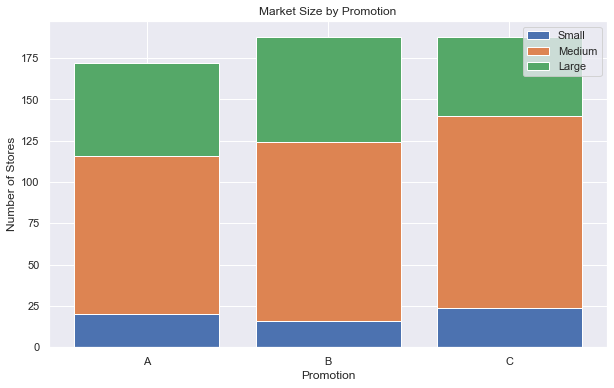

In [51]:
#Stacked bar chart to show observed distribution of market sizes in each group
fig, ax = plt.subplots(figsize=(10,6))

#Set x-axis to each promotion
x = sorted(df['Promotion'].unique())

#Set stacked bar heights to each market size
y1 = np.array(df.loc[df['MarketSizeCode']==1].groupby('Promotion').count()['MarketSize'])
y2 = np.array(df.loc[df['MarketSizeCode']==2].groupby('Promotion').count()['MarketSize'])
y3 = np.array(df.loc[df['MarketSizeCode']==3].groupby('Promotion').count()['MarketSize'])
y3_bottom = [y1[i] + y2[i] for i in range(len(x))]

#Create stacked bar charts
ax.bar(x,y1,label='Small')
ax.bar(x,y2,bottom=y1,label='Medium')
ax.bar(x,y3,bottom=y3_bottom,label='Large')

#Set labels
ax.set_title('Market Size by Promotion')
ax.set_ylabel('Number of Stores')
ax.set_xlabel('Promotion')
ax.set_xticks(ticks=x,labels=['A','B','C'])
ax.legend()

plt.show()

This chart shows us that there is a roughly equal number of small, medium, and large stores in each sample, suggesting that the samples are not biased with respect to market size. Let's test this more formally using a chi-squared test of independence, which tests the null hypothesis that there is no relationship between the market size and the promotion used:

In [68]:
#If chi_2 test p-value is lower than significance level, reject null hypothesis, otherwise do not reject null hypothesis
if stats.chi2_contingency(pd.crosstab(df['Promotion'],df['MarketSize']))[1] < 0.05:
    print('Reject null hypothesis - samples display market size bias')
else:
    print('Do not reject null hypothesis - samples do not display market size bias')

Do not reject null hypothesis - samples do not display market size bias


Let's also test for bias with respect to the age of the stores:

## 3. Ombibus Test

In this section I run the ANOVA test to determine whether the sales of the stores differ based on the marketing promotion used, i.e. is there a significant difference between the means of the three groups?

I begin by testing the assumptions of ANOVA - independence, equal variances, and normality. I find that the sales for each group are NOT normally distributed. Therefore, I opt to use the non-parametric equivalent of ANOVA: the Kruskal-Wallis test. 

### 3.1 ANOVA

The three assumptions of ANOVA are:

1. Independence 
2. Equal Variances
3. Normality

<p><img src="https://doctorlib.info/medical/biostatistics/biostatistics.files/image494.png" style="max-width:600px"></p>

Let's test each assumption in turn.

#### Independence 

Independence requires that there is no relationship between the observations within each group or between the groups themselves. That is, the same observation cannot appear in more than one group. In our case, this means that each store must use only one of the promotions.

This is typically a study design rather than something that is tested for. However, since I did not design this study myself, I will need to check to see whether the groups are in fact independent. I will do this by

In [989]:
#Function to check if samples meet independence assumption
def check_indep(A,B,C):
    
    result = 'Samples are independent'
    
    #Check if any member of group appears in more than one group 
    for x in A:
        for y in B:
            if x==y:
                result = 'Samples are not independent'
                
    for x in B:
        for y in C:
            if x==y:
                result = 'Samples are not independent'
                
    for x in A:
        for y in C:
            if x==y:
                result = 'Samples are not independent'
    
    return result

In [964]:
check_indep(A['LocationID'].unique(),B['LocationID'].unique(),C['LocationID'].unique())

'Groups are independent'

We can see that samples meet the independence assumption.

#### Equal Variances

The equal variance assumption requires that the variance of each group is roughly the same. There is no precise definition of what counts as 'equal variance', but there are some widely accepted rules of thumb to decide whether the variances are equal. I will use the heuristic that if the ratio of the larger variance to the smaller variance is less than 4, the sample variances are equal.

In [1213]:
#Function to check if samples meet equal variance assumption 
def check_var(A,B,C):
    
    variances = np.array([A.var(),B.var(),C.var()])
    
    #Sort samples variances from smallest to largest
    variances.sort()
    
    #Check ratio of smallest to largest variance:
    if variances[0]/variances[2] > 4:
        print('Unequal sample variances')
    else:
        print('Equal samples variances')

In [1214]:
check_var(A['Sales'],B['Sales'],C['Sales'])

Equal samples variances


#### Normality

The final assumption to check is normality. ANOVA assumes that each group is normally distributed. We will check this in two ways - visually using a histogram, and more formally using a Shapiro-Wilk test for normality.

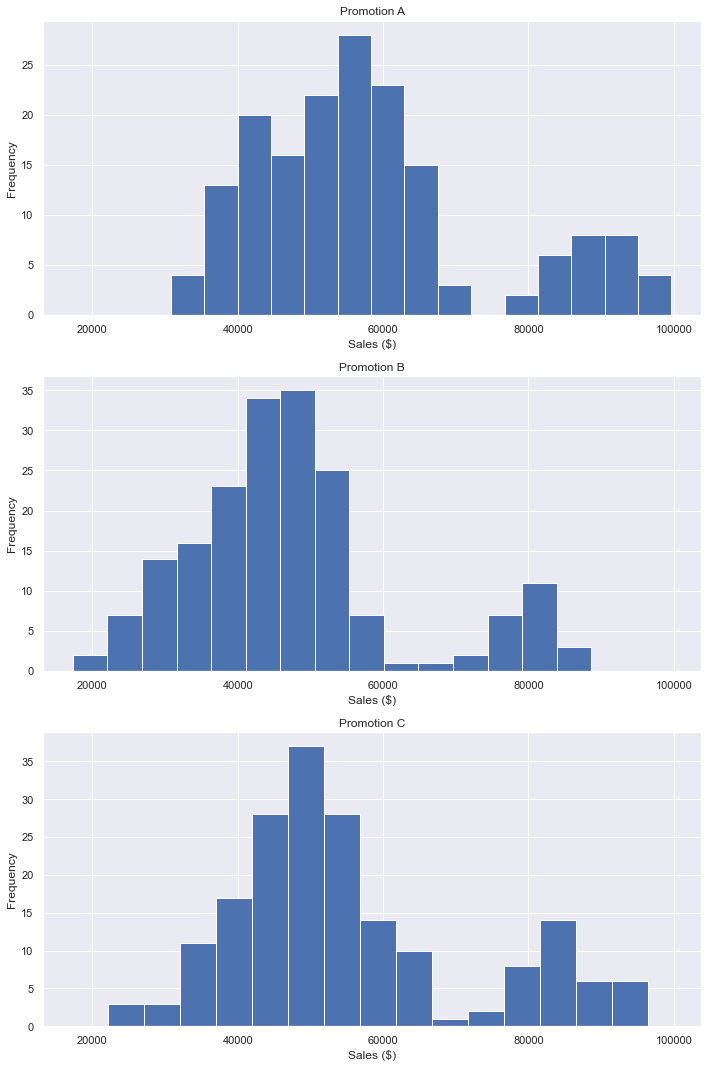

In [417]:
#Plot histograms of each promotion sales
fig, ax = plt.subplots(3,1,sharex=True)

fig.set_figheight(15)
fig.set_figwidth(10)

ax[0].hist(A,bins=15) 
ax[1].hist(B,bins=15)
ax[2].hist(C,bins=15)

ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)
ax[0].set_title('Promotion A')
ax[1].set_title('Promotion B')
ax[2].set_title('Promotion C')

for num in range(3):
    ax[num].set_xlabel('Sales ($)')
    ax[num].set_ylabel('Frequency')

plt.tight_layout()

In [112]:
data = {'Group': ['A','B','C'],
        'Null hypothesis': ['Sales are normally distributed'] * len(groups),
        'Critical Value': [0.05] * len(groups),
        'p-value': [],
        'Result': []}

groups = [A,B,C]
pval = []

for group in groups:
    pval.append(stats.shapiro(group)[1])
    
for value in pval:
    data['Result'].append('Reject null' if value < 0.05 else 'Do not reject null')
    data['p-value'].append(value)

pd.DataFrame(data)

,Group,Null hypothesis,Critical Value,p-value,Result
0,A,Sales are normally distributed,0.05,1.977292e-08,Reject null
1,B,Sales are normally distributed,0.05,5.456124e-09,Reject null
2,C,Sales are normally distributed,0.05,1.499486e-08,Reject null


Visually, we can see that the sales for each group are NOT normally distributed - instead they show a bimodal distribution. The first peak is centred around \$60,000, while the second is centred around \\$80-90,000.

The Shapiro-Wilk test also confirmed this - we rejected the null hypothesis that sales are normally distributed (p < 0.05).

The literature suggests that when samples sizes are large (n>30), ANOVA is relatively robust against violations of the normality assumption. However, most of the literature I found on this topic refers to skewed distributions rather than bimodal distributions. Moreover, although ANOVA is robust against normality violations, non-parametric tests tend to have more statistical power when this assumption is violated. As such, I will use the non-parametric alternative to ANOVA for this A/B/n test - the Kruskal-Wallis test.

### 3.2 Kruskal-Wallis Test

As our samples did not meet the assumptions of ANOVA, we will instead run a non-parametric Kruskal-Wallis test (also called 'ANOVA on ranks' as it ranks the data before comparing variability between and within groups).

If the distributions of the groups are similar, i.e. have similar shapes, then this test can be interpreted as testing for the difference between the medians of each groups (whereas ANOVA tests for the difference of means). We can use a violin plot to show that the distributions of each group are indeed similar:

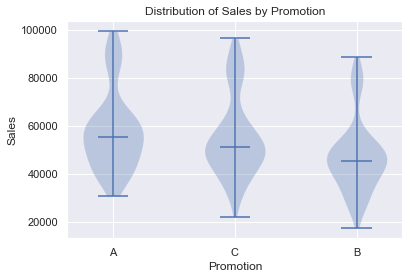

In [117]:
fig, ax = plt.subplots()

ax.violinplot([A,C,B],showmedians=True)

ax.set_ylabel('Sales')
ax.set_xlabel('Promotion')
ax.set_xticks(ticks=[1,2,3],labels=['A','C','B'])
ax.set_title('Distribution of Sales by Promotion')

plt.show()

Therefore, the null hypothesis for this test is:

   **Null hypothesis**: There is no difference among median sales for each promotion, i.e. A = B = C

**Alternative hypothesis**: At least one group differs from the overall median, i.e. (A ≠ B) or (A ≠ C) or (B ≠ C)

In [139]:
#Accept or reject null based on p-value and alpha
result = 'Do not reject null'
if stats.kruskal(A,B,C)[1] < 0.05:
    result = 'Reject null'

pd.DataFrame({'Median A':round(A.median()),
              'Median B':round(B.median()),
              'Median C':round(C.median()),
              'Null Hypothesis':'Median A = Median B = Median C',
              'Alpha':0.05,
              'p-value':stats.kruskal(A,B,C)[1],
              'Result':result
             },index=[0])

,Median A,Median B,Median C,Null Hypothesis,Alpha,p-value,Result
0,55385,45385,51165,Median A = Median B = Median C,0.05,2.674187e-12,Reject null


The Kruskal-Wallis test detected a significant difference in medians across the three groups (p < 0.05). Kruskall-Wallis is an omnibus test, and so it doesn't identify which promotion had a significant difference, or the direction of the difference. We must now use a post-hoc test to identify which promotion (if any) resulted in significantly higher sales of the burger in the first four weeks

## 4. Post-hoc tests

In this section I use Tukey's HSD test to compare every promotion against every other promotion, to identify which promotions had a significantly higher average sales compared to the others.

Each test has the same null and alternative hypothesis:

**Null Hypothesis:** There is no difference in mean sales between group 1 and group 2.

**Alternative Hypothesis:** There is a difference in mean sales between group 1 and group 2.

What changes between each test is the promotion used for group 1 and group 2. So for example, the first test compares the means of promotion A to promotion B, whereas the second compares the means of promotions A and C.

Each test has an alpha level of 0.05. The results are below:

In [137]:
print(pairwise_tukeyhsd(endog=df['Sales'],groups=df['Promotion'],alpha=0.05))

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------
     1      2 -10769.5967    0.0 -14773.8421 -6765.3514   True
     1      3  -2734.5435 0.2444  -6738.7889  1269.7018  False
     2      3   8035.0532    0.0   4120.8024  11949.304   True
--------------------------------------------------------------


Here are the results in a more interpretable format:

In [146]:
mean_a = round(A.mean())
mean_b = round(B.mean())
mean_c = round(C.mean())

tukeys_test_results = pd.DataFrame({'Group 1':['A','A','B'],
                            'Group 2':['B','C','C'],
                            'Group 1 Mean':[mean_a,mean_a,mean_b],
                            'Group 2 Mean':[mean_b,mean_c,mean_c],
                            'Mean Difference':[mean_a-mean_b,mean_a-mean_c,mean_b-mean_c],
                            'Null Hypothesis':['Mean A = Mean B','Mean A = Mean C','Mean B = Mean C'],
                            'p-value':['<0.001','0.244','<0.001'],
                            'Result':['Reject Null','Do Not Reject Null','Reject Null']
                           })

tukeys_test_results

,Group 1,Group 2,Group 1 Mean,Group 2 Mean,Mean Difference,Null Hypothesis,p-value,Result
0,A,B,58099,47329,10770,Mean A = Mean B,<0.001,Reject Null
1,A,C,58099,55364,2735,Mean A = Mean C,0.244,Do Not Reject Null
2,B,C,47329,55364,-8035,Mean B = Mean C,<0.001,Reject Null


The results of the Tukey test indicate two key insights:

1. Stores using promotion A and C had significantly higher sales than stores using promotion B.
2. There is no significant difference between the sales of stores using promotion A and C.

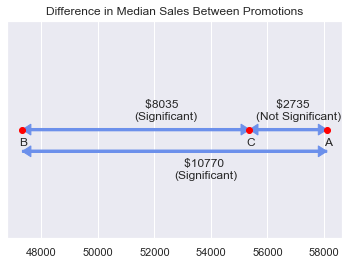

In [415]:
fig, ax = plt.subplots()

ax.plot(B.mean(), 0, marker="o", color='Red')
ax.plot(C.mean(), 0, marker="o", color='Red')
ax.plot(A.mean(), 0, marker="o", color='Red')

ax.arrow(x=B.mean(),y=0,dx=(C.mean()-B.mean()),dy=0,
         length_includes_head=True,width=0.02,head_length=300,head_width=0.1,color='#6c90eb')
ax.arrow(x=C.mean(),y=0,dx=-(C.mean()-B.mean()),dy=0,
         length_includes_head=True,width=0.02,head_length=300,head_width=0.1,color='#6c90eb')
ax.arrow(x=C.mean(),y=0,dx=(A.mean()-C.mean()),dy=0,
         length_includes_head=True,width=0.02,head_length=300,head_width=0.1,color='#6c90eb')
ax.arrow(x=A.mean(),y=0,dx=-(A.mean()-C.mean()),dy=0,
         length_includes_head=True,width=0.02,head_length=300,head_width=0.1,color='#6c90eb')
ax.arrow(x=B.mean(),y=-0.2,dx=(A.mean()-B.mean()),dy=0,
         length_includes_head=True,width=0.02,head_length=300,head_width=0.1,color='#6c90eb')
ax.arrow(x=A.mean(),y=-0.2,dx=-(A.mean()-B.mean()),dy=0,
         length_includes_head=True,width=0.02,head_length=300,head_width=0.1,color='#6c90eb')

ax.annotate('A',[A.mean()-100,-0.15])
ax.annotate('B',[B.mean()-100,-0.15])
ax.annotate('C',[C.mean()-100,-0.15])
ax.annotate('   $8035\n(Significant)',[51300,0.09])
ax.annotate('      $2735\n(Not Significant)',[55600,0.09])
ax.annotate('   $10770\n(Significant)',[52700,-0.45])

ax.set_ylim(-1,1)
ax.set_yticks([])
ax.set_title('Difference in Median Sales Between Promotions')

plt.show()

This shows that the difference between A and B is significant the difference between B and C is significant, but the different between A and C is not significant. 

Stores which used promotion A and C both showed significantly higher sales in the first 4 weeks. While stores using promotion A showed slightly higher sales than promotion C (~$2700), this difference was found to not be significant.

## 5. Conclusion

What conclusions can be drawn from this analysis? Let's return to our original hypothesis statement:

*We believe that at least one of the three marketing promotions will result in significantly higher sales of the burger in the first four weeks across randomly selected stores.* 

In order to test this, we first ran an omnibus test. As the sales data were not normally distributed, we used a non-parametric Kruskal-Wallis test. The result of this test indicated that the median sales were not all the same - there was a significant difference in sales for at least one of the groups.

In order to determine which of these groups is significantly different, we ran a post-hoc Tukey's HSD test. The result of this test indicated that stores using promotion A and C had higher sales than those using promotion B, and this difference was significant (p < 0.05). 

Since the difference between A and C was not found to be significant, the fast food restaurant could use either of the two promotions. However, our findings showed that they should not use promotion B to market the new burger.

How could we improve the study?

- Add control group with no marketing campaign. Can tell if there is any point running the campaign at all.
- Control for market size better
- Control for market better
- Control for age of store better

## 6. References

Anasatasiia Chebotina's Notebook:
https://www.kaggle.com/code/chebotinaa/a-b-testing-of-fast-food-marketing-campaign/notebook

Yunus Turkoglu's Notebook:
https://www.kaggle.com/code/yunusemreturkoglu/ab-testing-anova

ANOVA in Python:
https://www.kaggle.com/code/hamelg/python-for-data-26-anova/notebook

Calculating sample size:
https://www.youtube.com/watch?v=KC1nwY7YCUE

A/B Testing Notebook:
https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing

A/B Testing Video:
https://www.youtube.com/watch?v=DUNk4GPZ9bw

Hypothesis Statement:
https://www.optimizely.com/insights/blog/why-an-experiment-without-a-hypothesis-is-dead-on-arrival/#:~:text=A%20hypothesis%20is%20a%20prediction,%2C%20not%20open%2Dended%20questions.

MDE:
https://towardsdatascience.com/how-to-set-the-minimum-detectable-effect-in-ab-tests-fe07f8002d6d

Power:
https://www.youtube.com/watch?v=6_Cuz0QqRWc

Multiple comparison tests:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6193594/

Kruskal-Wallis test:
https://influentialpoints.com/Training/Kruskal-Wallis_ANOVA_use_and_misuse.htm#:~:text=The%20Kruskal%2DWallis%20one%2Dway,test%20of%20dominance%20between%20distributions.

ANOVA Assumptions:
https://www.quality-control-plan.com/StatGuide/oneway_anova_ass_viol.htm#Non-normality